Fetching the packages 

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Downloading the dataset from Kaggle

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  61.5M      0  0:00:12  0:00:12 --:--:-- 42.8M


Unzip the dataset

In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls


 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


Deleting the corrupted images

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


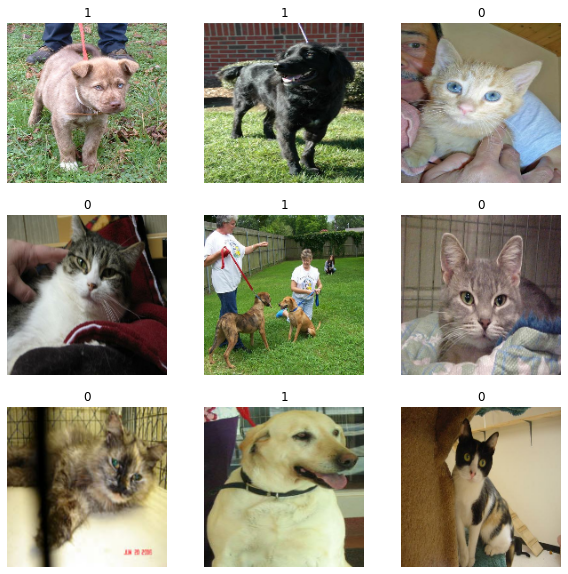

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

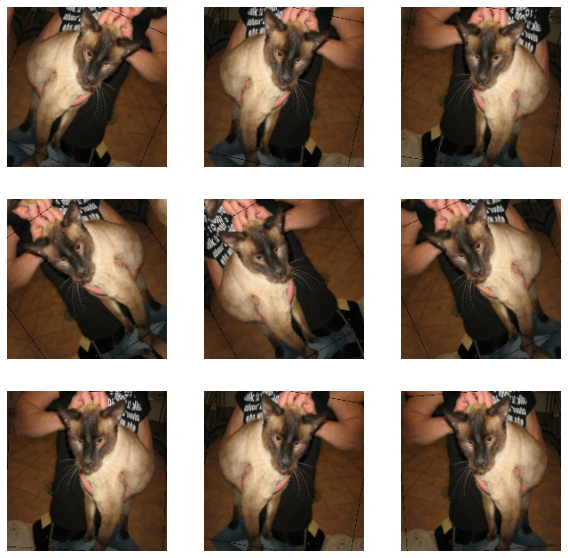

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


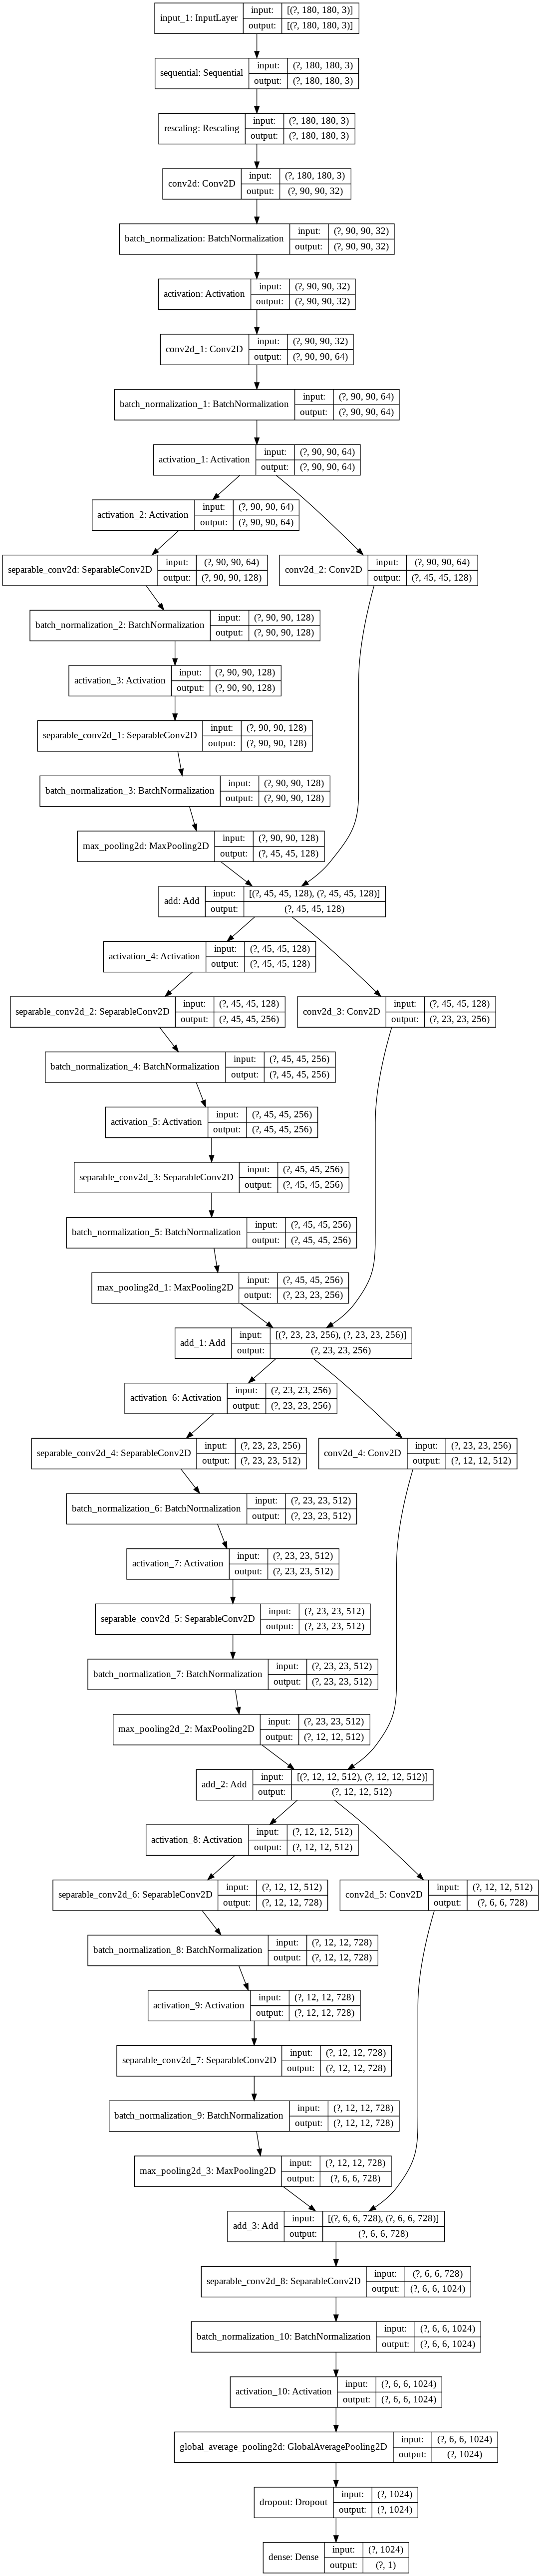

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/25
586/586 [==============================] - 114s 194ms/step - loss: 0.6392 - accuracy: 0.6530 - val_loss: 0.9184 - val_accuracy: 0.5547
Epoch 2/25
586/586 [==============================] - 113s 193ms/step - loss: 0.4845 - accuracy: 0.7696 - val_loss: 0.5330 - val_accuracy: 0.7659
Epoch 3/25
586/586 [==============================] - 113s 192ms/step - loss: 0.3931 - accuracy: 0.8245 - val_loss: 0.6768 - val_accuracy: 0.7018
Epoch 4/25
586/586 [==============================] - 113s 192ms/step - loss: 0.3314 - accuracy: 0.8546 - val_loss: 0.3556 - val_accuracy: 0.8518
Epoch 5/25
586/586 [==============================] - 113s 192ms/step - loss: 0.2755 - accuracy: 0.8834 - val_loss: 0.3974 - val_accuracy: 0.8274
Epoch 6/25
586/586 [==============================] - 113s 192ms/step - loss: 0.2324 - accuracy: 0.9019 - val_loss: 0.3064 - val_accuracy: 0.8676
Epoch 7/25
586/586 [==============================] - 113s 192ms/step - loss: 0.2057 - accuracy: 0.9143 - val_loss: 0.3472 -

In [14]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 113s 193ms/step - loss: 0.0908 - accuracy: 0.9654 - val_loss: 0.1359 - val_accuracy: 0.9475
Epoch 2/50
586/586 [==============================] - 113s 192ms/step - loss: 0.0876 - accuracy: 0.9662 - val_loss: 0.0982 - val_accuracy: 0.9616
Epoch 3/50
586/586 [==============================] - 113s 192ms/step - loss: 0.0831 - accuracy: 0.9662 - val_loss: 0.1050 - val_accuracy: 0.9592
Epoch 4/50
586/586 [==============================] - 113s 192ms/step - loss: 0.0790 - accuracy: 0.9693 - val_loss: 0.0949 - val_accuracy: 0.9639
Epoch 5/50
586/586 [==============================] - 112s 192ms/step - loss: 0.0813 - accuracy: 0.9687 - val_loss: 0.1284 - val_accuracy: 0.9537
Epoch 6/50
586/586 [==============================] - 113s 192ms/step - loss: 0.0812 - accuracy: 0.9679 - val_loss: 0.0943 - val_accuracy: 0.9607
Epoch 7/50
586/586 [==============================] - 112s 192ms/step - loss: 0.0758 - accuracy: 0.9714 - val_loss: 0.1461 -

Saving the model

In [36]:

# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model1.h5') 

INFO:tensorflow:Assets written to: saved_model/my_model1/assets


Testing with a dog image

In [32]:
from PIL import Image
import requests
from io import BytesIO


image_url = input("Enter the URL you would like to download: ")
image = requests.get(image_url)
with open('pic1.jpg', 'wb') as outfile:
    outfile.write(image.content)



Enter the URL you would like to download: https://cdn.akc.org/content/article-body-image/golden_puppy_dog_pictures.jpg


In [33]:
i = keras.preprocessing.image.load_img(
    "pic1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(i)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


This image is 0.00 percent cat and 100.00 percent dog.


Now testing with a cat image

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:
model_save_name = 'Jayam_Week4.h5'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.save(path)

In [19]:

from PIL import Image
import requests
from io import BytesIO


image_url = input("Enter the URL you would like to download: ")
image = requests.get(image_url)
with open('pic1.jpg', 'wb') as outfile:
    outfile.write(image.content)



Enter the URL you would like to download: https://ichef.bbci.co.uk/news/1024/cpsprodpb/151AB/production/_111434468_gettyimages-1143489763.jpg


In [20]:
i = keras.preprocessing.image.load_img(
    "pic1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(i)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


This image is 76.02 percent cat and 23.98 percent dog.
